<a href="https://colab.research.google.com/github/swicklund/hackathon/blob/main/MLModel1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import os

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import fastbook as fastai
import pandas as pd
from pandas.io.json import json_normalize
import seaborn as sns
import tensorflow as tf
import json
import zipfile
from io import BytesIO
import torch
import math
from google.colab import files
from google.colab import auth
from datetime import datetime, timedelta

fastai.setup_book()
from fastai import tabular


In [59]:
!pip install dtreeviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 107 kB/s 
  Created wheel for dtreeviz: filename=dtreeviz-1.3.6-py3-none-any.whl size=67326 sha256=bc81296bb2e29541e2cc1fdde2c2c9835ab987c88689949736b65190c4f098b4
  Stored in directory: /root/.cache/pip/wheels/33/76/fe/99227ff871766e7284bb88d3d28e2f4886b8ec04d669033478
Successfully built dtreeviz


In [60]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [2]:
auth.authenticate_user()

In [3]:
!gcloud config set project {'hackathon-352519'}

Updated property [core/project].


In [4]:
!gsutil cp gs://trains_data/* /tmp/.

Copying gs://trains_data/train-data_all-train-events.zip...
\ [1 files][ 57.1 MiB/ 57.1 MiB]                                                
Operation completed over 1 objects/57.1 MiB.                                     


In [5]:
trains = {}
i = 1
prevLoco = ''
with zipfile.ZipFile("/tmp/train-data_all-train-events.zip", "r") as f:
    for name in f.namelist():
        if name.endswith('.json'):
            with f.open(name) as zd:
                data = json.load(zd)
                lastTrainReporting = data['lastTrainReporting']
                currentLoco = lastTrainReporting['ptcLeadLocomotiveId']
                # prevLoco != currentLoco and 
                if ("trainActualPositionList" in lastTrainReporting and len(lastTrainReporting['trainActualPositionList']) > 0): 
                    trainActualPositionList = lastTrainReporting['trainActualPositionList']
                    trains[i] = pd.json_normalize(lastTrainReporting)
                    i = i + 1
                    if (i % 1000 == 0):
                      current_time = datetime.now().strftime("%H:%M:%S")
                      print(i, " ", current_time)
                    prevLoco = currentLoco
                            

1000   16:32:55
2000   16:33:07
3000   16:33:12
4000   16:33:18
5000   16:33:23
6000   16:33:28
7000   16:33:34
8000   16:33:40
9000   16:33:45
10000   16:33:51


In [6]:
dfTrainsAll = pd.concat(trains.values())
dfTrainsAll["milepost"] = dfTrainsAll.apply(lambda row: math.trunc(row['lastReportedPosition.milepostLocation.milepost.milepostNumber']), axis=1)

In [7]:
del trains

In [8]:
print(dfTrainsAll.info())
print(dfTrainsAll.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10054 entries, 0 to 0
Data columns (total 45 columns):
 #   Column                                                                     Non-Null Count  Dtype  
---  ------                                                                     --------------  -----  
 0   ptcLeadLocomotiveId                                                        10054 non-null  object 
 1   maximumTrainSpeed                                                          10053 non-null  float64
 2   loadedCarCount                                                             10053 non-null  float64
 3   emptyCarCount                                                              10053 non-null  float64
 4   trainLength                                                                10053 non-null  float64
 5   trailingTonnage                                                            10053 non-null  float64
 6   positionHistoryList                                       

In [9]:
dfTrainsLearn = dfTrainsAll
dfTrainsLearn['lastReportedPosition.milepostLocation.trackName'] = dfTrainsLearn['lastReportedPosition.milepostLocation.trackName'].astype('category')
dfTrainsLearn['lastReportedPosition.milepostLocation.trackName'] = dfTrainsLearn['lastReportedPosition.milepostLocation.trackName'].cat.set_categories(['WEST MAIN', 'MAIN', 'MT 2', 'MT 1', 'WESTXO', 'XO', 'EASTXO','YD LD', 'EAST MAIN', 'TO_N_EAST MAIN', 'TO_S_UP_MAINLINE', 'TO_S_CS JUNCTION', 'S_STARKS', 'TO_S_KCS UP PRT CONN', 'TO_N_LUCAS', 'S_LUCAS'])
dfTrainsLearn['lastReportedSpeedMPH'] = dfTrainsLearn.apply(lambda row: row['positionHistoryList'][0]['speedMPH'], axis=1)
dfTrainsLearn['symbolType'] = dfTrainsLearn.apply(lambda row: row['trainId.trainSymbol'][:1], axis=1)
dfTrainsLearn['symbolType'] = dfTrainsLearn['symbolType'].astype('category')
dfTrainsLearn['symbolType'] = dfTrainsLearn['symbolType'].cat.set_categories(['M', 'I', 'Z', 'C', 'W', 'E', 'U'])


In [28]:
def getWorkLocations(dfTrainsLocation):
  if len(dfTrainsLocation['aotuTrainData.routeLocationList']) == 0:
    return None
  aotuRoute=pd.json_normalize(dfTrainsLocation['aotuTrainData.routeLocationList']) 
  eventLocations = aotuRoute[aotuRoute['activityList'].map(len) > 1]
  temp = eventLocations['milepost.milepostNumber'].unique()
  if len(temp) == 0:
    return None
  return ','.join(['%.2f' % num for num in temp])

In [ ]:
#getWorkLocations(dfTrainsLearn.iloc[301])

In [13]:
#dfTrainsLearn.loc[dfTrainsLearn['aotuTrainData.routeLocationList'].map(len)==0]

In [29]:
dfTrainsLearn['workLocations'] = dfTrainsLearn.apply(lambda row: getWorkLocations(row), axis=1)

In [50]:
dfTrainsLearn['workLocations'].unique()

array([None, '202.20', '258.40,202.20', '202.20,258.40', '202.20,258.40,321.50', '202.92,202.20', '225.10,202.20', '240.90,202.20'], dtype=object)

We can make this more clever later, but for now this seems the most sensible shortcut

In [31]:
dfTrainsLearn['locomotiveCount'] = dfTrainsLearn.apply(lambda row: len(row['locomotiveList']),axis = 1)

In [32]:
dfTrainsLearnActuals = dfTrainsLearn.apply(lambda row: pd.json_normalize(row['trainActualPositionList']), axis=1)

In [33]:
dfTrainsLearnActuals.iloc[1]

,positionTime,speedMPH,milepostLocation.subdivisionId,milepostLocation.trackName,milepostLocation.milepost.milepostNumber
0,2022-04-21T23:34:11Z,-10,106,WEST MAIN,766.36030
1,2022-04-21T23:36:11Z,-10,106,MAIN,766.01776
2,2022-04-21T23:38:11Z,-9,106,MAIN,765.68665
3,2022-04-21T23:40:11Z,-8,106,MAIN,765.38310
4,2022-04-21T23:42:11Z,-9,106,MAIN,765.07520


In [65]:
def findNextSpeed(trainsEntry, actualsEntry):
  milepost = trainsEntry['lastReportedPosition.milepostLocation.milepost.milepostNumber']
  #print(milepost)
  value  = actualsEntry.loc[actualsEntry['milepostLocation.milepost.milepostNumber'] > milepost+1]
  if (len(value) > 0):
    return (value.min()['speedMPH'] - trainsEntry['lastReportedPosition.speedMPH'])
  value  = actualsEntry.loc[actualsEntry['milepostLocation.milepost.milepostNumber'] < milepost-1]
  if (len(value) > 0):
    return (value.max()['speedMPH'] - trainsEntry['lastReportedPosition.speedMPH'])
  return None

In [66]:
dfTrainsLearn['nextSpeed'] = dfTrainsLearn['lastReportedPosition.speedMPH']
i = 0;
for index, trainsEntry in dfTrainsLearn.iterrows():
  actualsEntry = dfTrainsLearnActuals.iloc[i]
  nextSpeed = findNextSpeed(trainsEntry, actualsEntry)
  if (nextSpeed != None):
    trainsEntry['nextSpeed'] = nextSpeed
  if (i % 1000 == 0):
    print(i)
  i = i + 1

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  if __name__ == '__main__':


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [68]:
# dfTrainsLearn = dfTrainsLearn.drop(['hour'], axis=1)
dfTrainsLearn['nextSpeed'].unique()

array([-12, -11, -10,  -8, -56, -58, -55, -43, -29, -34,   0, -22, -28, -27, -65, -68, -70, -67, -64, -71, -69, -62, -59, -61, -66, -48, -50, -53, -60, -52, -47, -46, -38, -37, -51, -17, -36, -41,
       -63,  38,  50,  61,  62,  58,  59,  63,  67,  68,  69,  53,  39,  37,  41,  66,  64,  60,  65,  36,  46,  47,  49,  51,  48,  45,  54,  56,  55,  52,  70,  57,  43,  42, -45, -40, -49, -57,
       -54, -44, -39,  21,   9,   8,  27,  34,  31,  28,  35,  44,  24,  25,  26,  29,  30,  40,  23,  20,  11,  16,  32, -35, -32, -33, -31, -30, -25, -23, -26, -42, -20, -21, -19, -24, -16, -15,
        -5,  -9, -14, -13,  -2,  -7, -18,  -1,  -6,  22,  13,   6,   5,  33,  19,  17,  10,   7,   3,  14,  12,  15,  18,   2,   1,  -3,  -4,   4])

Drop some values we are not using at the moment not needed

In [37]:
dfTrainsLearn = dfTrainsLearn.drop(columns=['aotuTrainData.tenantCarrier',
                                            'lastReportedPosition.precedingSignalState.currentStateTime', 
                                            'lastReportedPosition.nextSignalState.previousSignalState', 
                                            'lastReportedPosition.nextSignalState.currentStateTime', 
                                            'positionHistoryList',
                                            'locomotiveList',
                                            'subdivisionList',
                                            'trainActualPositionList',
                                            'trainEstimatedPositionList',
                                            'aotuTrainData.routeLocationList'])

In [ ]:
tabular.core.make_date(dfTrainsLearn, 'trainId.trainDate')
tabular.core.make_date(dfTrainsLearn, 'lastReportedPosition.positionTime')
tabular.core.add_datepart(dfTrainsLearn, 'lastReportedPosition.positionTime')
# tabular.core.add_elapsed_times(dfTrainsLearn, 'lastReportedPosition.positionTime')


In [67]:
print(dfTrainsLearn.shape)
print(dfTrainsLearnActuals.shape)

print(dfTrainsLearn.info())
print(dfTrainsLearn.iloc[100])

(10054, 52)
(10054,)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10054 entries, 0 to 0
Data columns (total 52 columns):
 #   Column                                                                     Non-Null Count  Dtype         
---  ------                                                                     --------------  -----         
 0   ptcLeadLocomotiveId                                                        10054 non-null  object        
 1   maximumTrainSpeed                                                          10053 non-null  float64       
 2   loadedCarCount                                                             10053 non-null  float64       
 3   emptyCarCount                                                              10053 non-null  float64       
 4   trainLength                                                                10053 non-null  float64       
 5   trailingTonnage                                                            10053 non-null  f

# Use Decision Tree to predict speed in 1 mile

In [69]:
procs = [tabular.core.Categorify, tabular.core.FillMissing]

In [70]:
print (dfTrainsLearn.groupby(['lastReportedPosition.positionTimeDayofyear'])['lastReportedPosition.positionTimeDayofyear'].count())


lastReportedPosition.positionTimeDayofyear
90     124
91     271
92      79
93     106
95     109
      ... 
121     45
122    247
123    214
124    237
125    150
Name: lastReportedPosition.positionTimeDayofyear, Length: 33, dtype: int64


In [71]:
cond = ( dfTrainsLearn['lastReportedPosition.positionTimeDayofyear'] < 121 )
trainIdx = np.where(cond)[0]
validIdx = np.where(~cond)[0]
splits = (list(trainIdx), list(validIdx))

In [72]:
dep_var = 'nextSpeed'

In [73]:
cont,cat = tabular.core.cont_cat_split(dfTrainsLearn, 1, dep_var=dep_var)

In [74]:
to = tabular.core.TabularPandas(dfTrainsLearn, procs, cat, cont, y_names=dep_var, splits=splits)

In [75]:
len(to.train),len(to.valid)

(9161, 893)

In [76]:
to.show()

,ptcLeadLocomotiveId,trainId.trainSCAC,trainId.trainSection,trainId.trainSymbol,trainId.trainDate,lastReportedPosition.milepostLocation.subdivisionId,lastReportedPosition.milepostLocation.trackName,aotuTrainData.ownershipCode,aotuTrainData.eventCode,symbolType,workLocations,lastReportedPosition.positionTimeYear,lastReportedPosition.positionTimeIs_month_end,lastReportedPosition.positionTimeIs_month_start,lastReportedPosition.positionTimeIs_quarter_end,lastReportedPosition.positionTimeIs_quarter_start,lastReportedPosition.positionTimeIs_year_end,lastReportedPosition.positionTimeIs_year_start,maximumTrainSpeed_na,loadedCarCount_na,emptyCarCount_na,trainLength_na,trailingTonnage_na,lastReportedPosition.precedingSignalState.milepostLocation.milepostNumber_na,lastReportedPosition.precedingSignalState.previousSignalState_na,lastReportedPosition.precedingSignalState.signalState_na,lastReportedPosition.nextSignalState.milepostLocation.milepostNumber_na,lastReportedPosition.nextSignalState.signalState_na,maximumTrainSpeed,loadedCarCount,emptyCarCount,trainLength,trailingTonnage,lastReportedPosition.speedMPH,lastReportedPosition.milepostLocation.milepost.milepostNumber,aotuTrainData.priorityCode,aotuTrainData.categoryCode,aotuTrainData.authorityRangeCode,aotuTrainData.totalCarWeight,aotuTrainData.totalCarLength,aotuTrainData.totalLocomotiveWeight,aotuTrainData.totalLocomotiveLength,aotuTrainData.actualTonsPerAxle,aotuTrainData.heavy143TonCarCount,aotuTrainData.heavy158TonCarCount,aotuTrainData.over158TonCarCount,aotuTrainData.highWideCarCount,lastReportedPosition.precedingSignalState.milepostLocation.milepostNumber,lastReportedPosition.precedingSignalState.previousSignalState,lastReportedPosition.precedingSignalState.signalState,lastReportedPosition.nextSignalState.milepostLocation.milepostNumber,lastReportedPosition.nextSignalState.signalState,milepost,lastReportedSpeedMPH,locomotiveCount,lastReportedPosition.positionTimeMonth,lastReportedPosition.positionTimeWeek,lastReportedPosition.positionTimeDay,lastReportedPosition.positionTimeDayofweek,lastReportedPosition.positionTimeDayofyear,lastReportedPosition.positionTimeElapsed,nextSpeed
0,UP2010,UP,,MEWLI,2022-04-21,106,WEST MAIN,2,0,M,#na#,2022,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,50.0,61.0,92.0,9282.0,10992.0,-12,766.930420,4,12,2,219727008.0,1078840.0,12202400.0,25820.0,65535.0,10,0,0,0,258.420013,-4.0,1.0,260.200012,1.0,766,-12,2,4,16,21,3,111,1.650584e+09,-12
0,UP2010,UP,,MEWLI,2022-04-21,106,WEST MAIN,2,0,M,#na#,2022,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,50.0,61.0,92.0,9282.0,10992.0,-11,766.718811,4,12,2,219727008.0,1078840.0,12202400.0,25820.0,65535.0,10,0,0,0,258.420013,-4.0,1.0,260.200012,1.0,766,-11,2,4,16,21,3,111,1.650584e+09,-11
0,UP2010,UP,,MEWLI,2022-04-21,106,WEST MAIN,2,0,M,#na#,2022,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,50.0,61.0,92.0,9282.0,10992.0,-10,766.565308,4,12,2,219727008.0,1078840.0,12202400.0,25820.0,65535.0,10,0,0,0,258.420013,-4.0,1.0,260.200012,1.0,766,-10,2,4,16,21,3,111,1.650584e+09,-10
0,UP2010,UP,,MEWLI,2022-04-21,106,WEST MAIN,2,0,M,#na#,2022,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,50.0,61.0,92.0,9282.0,10992.0,-10,766.435181,4,12,2,219727008.0,1078840.0,12202400.0,25820.0,65535.0,10,0,0,0,258.420013,-4.0,1.0,260.200012,1.0,766,-10,2,4,16,21,3,111,1.650584e+09,-10
0,UP2010,UP,,MEWLI,2022-04-21,106,WEST MAIN,2,0,M,#na#,2022,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,50.0,61.0,92.0,9282.0,10992.0,-10,766.322815,4,12,2,219727008.0,1078840.0,12202400.0,25820.0,65535.0,10,0,0,0,258.420013,-4.0,1.0,260.200012,1.0,766,-10,2,4,16,21,3,111,1.650584e+09,-10
0,UP2010,UP,,MEWLI,2022-04-21,106,WEST MAIN,2,0,M,#na#,2022,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,5

In [77]:
fastai.save_pickle('/tmp/to.pkl',to)

# Creating the Decision Tree

In [78]:
to = fastai.load_pickle('/tmp/to.pkl')

In [79]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [85]:
m = DecisionTreeRegressor(min_samples_leaf=10)
m.fit(xs, y);

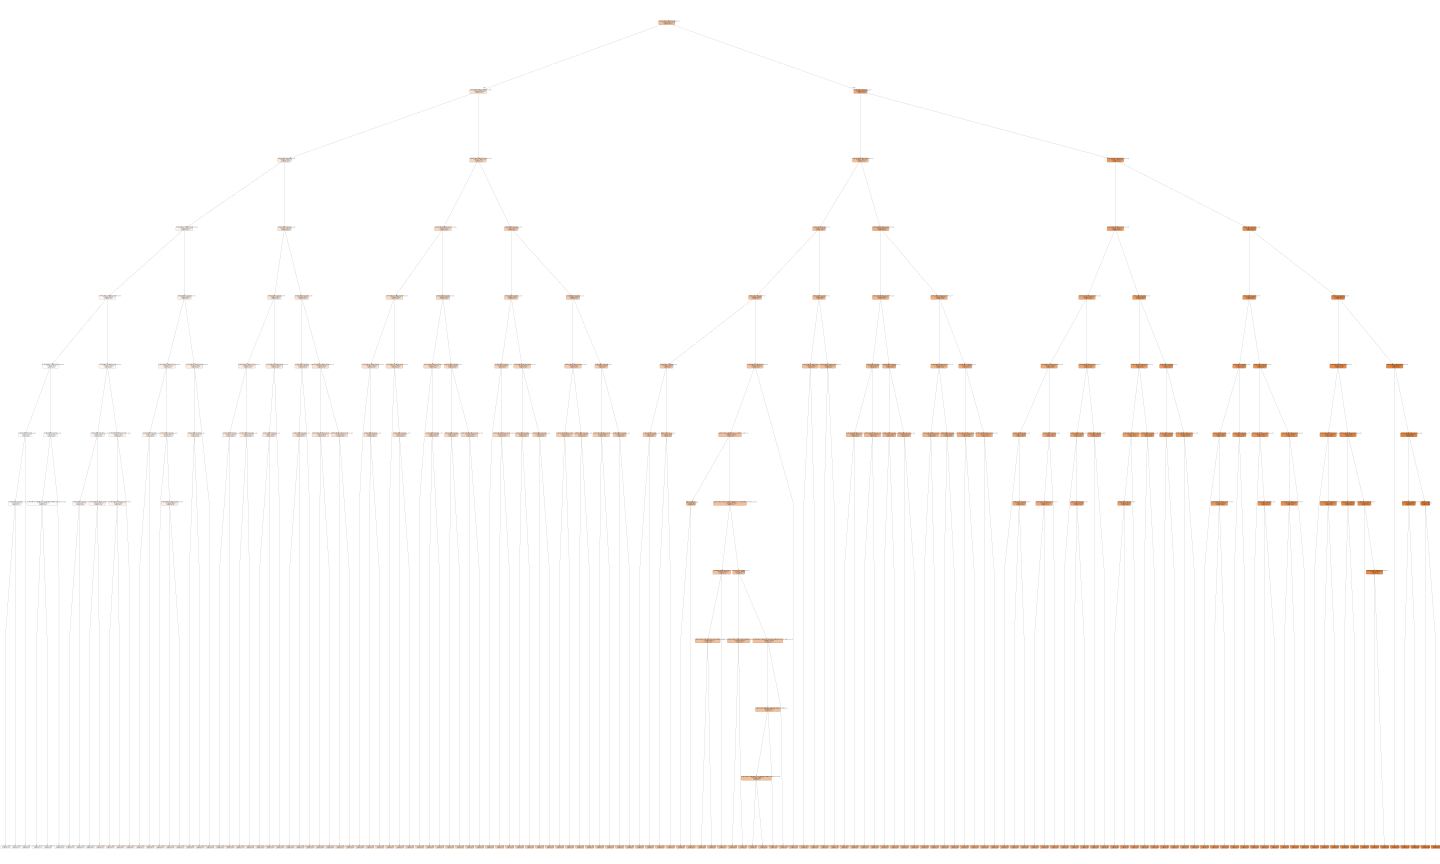

In [86]:
fastai.draw_tree(m, xs, size=20, leaves_parallel=True, precision=2)

In [87]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [88]:
m_rmse(m, xs, y)

0.087291

In [89]:
m_rmse(m, valid_xs, valid_y)

0.173346

Our first result! It appears the previous speed is so haevily influencing the next speed, it swamps everything else.

In [164]:
def rf(xs, y, n_estimators=40, max_samples=4500,
       max_features=0.5, min_samples_leaf=7, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [165]:
m = rf(xs, y);

In [166]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.228098, 0.539397)

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [168]:
r_mse(preds.mean(0), valid_y)

0.539397

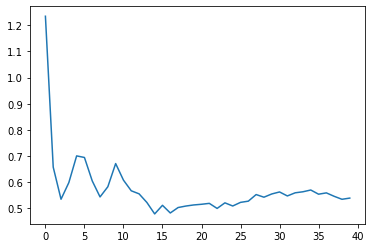

In [170]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

#OLD CODE

In [ ]:
def formatTrain(dfTrain):
  actuals = pd.json_normalize(dfTrain['trainActualPositionList'])
  cols = list(actuals.columns)
  dfx = (actuals[cols[0:2] + cols[3:5]])
  dfx = dfx.rename(columns={"speedMPH" : "speedMPH", "milepostLocation.trackName":"trackName", "milepostLocation.milepost.milepostNumber": "milepostNumber" })
  est = pd.json_normalize(dfTrain['trainEstimatedPositionList'])  
  beop = est.rename(columns={"speedMPH" : "forecastSpeedMPH", "milepostLocation.trackName":"forecastTrackName", "milepostLocation.milepost.milepostNumber": "forecastMilepostNumber" })
  joined = beop.join(dfx, lsuffix='_beop', rsuffix='_actual')
  dn = joined.dropna()
  dn = dn.loc[(dn['speedMPH'] != 0)]
  delta = abs(dn["speedMPH"] - dn["forecastSpeedMPH"]);
  #dn = dn.apply(lambda x: abs(x) if x.name=='speedMPH' or  x.name=='forecastSpeedMPH' else x)
  dn["delta"] = delta
  try:
    dn['milepost'] = dn.apply(lambda row: math.trunc(row['milepostNumber']), axis=1) 
    dn['millis'] = dn.apply(lambda row: ((datetime.strptime(row['positionTime_actual'], "%Y-%m-%dT%H:%M:%SZ"))  - datetime(1970, 1, 1)) // timedelta(milliseconds=1), axis=1)
  except ValueError:
    print (ValueError)
    print("Oops!  invalid format", dn)
  dn['trainId'] = dfTrain['trainId.trainSymbol']+" "+dfTrain['trainId.trainDate']
  dn = dn.drop(columns=['milepostLocation.subdivisionId'])
  # dn = dn.reset_index()
  return dn

In [ ]:
def convertTrains(trainSet): 
  trainsList = []
  for index, train in trainSet.iterrows():
    # print(train['trainId.trainSymbol'])
    trainsList.append(formatTrain(train))
  trains = pd.concat(trainsList)
  trains = trains.sort_values(['trainId','positionTime_actual'])
  trains = trains.drop_duplicates(subset=['trainId', 'milepost'], keep='last')
  trains = trains.reset_index()
  return trains

In [ ]:
trains = convertTrains(dfTrains)

In [ ]:
def getTrain(trains, symbol):
  return trains.loc[trains['trainId'].str.startswith(symbol)]

In [ ]:
getTrain(trains, 'MALNP')

Compute the Change of Velocity entering each milepost segment

In [ ]:
def computeSpeedChange(trains):
  trains['speedChange'] = trains["speedMPH"]
  prevTrain = ''
  for i in range(0, len(trains)):
    if trains.loc[i, "trainId"] == prevTrain :
      trains.loc[i, "speedChange"] = trains.loc[i, "speedMPH"] - trains.loc[i-1, "speedMPH"]
    else :  
      trains.loc[i, "speedChange"] = 0.0
    prevTrain = trains.loc[i, "trainId"]
  return trains

In [ ]:
trains = computeSpeedChange(trains)
trains

In [ ]:
mps = trains['milepost'].unique()
mps.sort()
mps

In [ ]:
print(trains.iloc[0])

In [ ]:
def printAllReadings(trainSet, trainSymbol):
  with pd.option_context('display.max_rows', None,
                        'display.max_columns', None,
                        'display.width', 1000,
                        'display.precision', 3,
                        ):
    vals = trainSet.loc[trainSet['trainId'] == trainSymbol]
    #vals= vals.sort_values('positionTime_actual')
    print(vals[['index', 'positionTime_actual', 'milepost', 'milepostNumber','forecastSpeedMPH', 'speedMPH', 'speedChange']])

In [ ]:
printAllReadings(trains, 'ITAG3 2022-04-20')

In [ ]:
dfTrains.iloc[3]["trainEstimatedPositionList"]                                                   

In [ ]:
dfTrains.iloc[3]

In [ ]:
def plotTrain(trainData, trainId):
  ax = plt.gca()
  trainDF = trainData.loc[trainData['trainId'] == trainId]
  trainDF = trainDF.reset_index();
  trainsDF = trainDF.sort_values('positionTime_actual')
  trainDF = trainDF.apply(lambda x: abs(x) if x.name=='speedMPH' or  x.name=='forecastSpeedMPH' else x)  
  trainDF.plot(x = 'milepostNumber', y="speedMPH", use_index=True, kind="scatter", ax=ax, figsize=[24,10])
  trainDF.plot(x = 'milepostNumber', y="forecastSpeedMPH", use_index=True, kind="scatter", color="red", ax=ax, figsize=[24,10])
  trainDF.plot(x = 'milepostNumber', y="delta", use_index=True, kind="line", color="green", ax=ax, figsize=[24,10])
  # plt.gcf().autofmt_xdate()
  (t,b)= ax.get_xlim()  ## Added for clarity
  if t < b:
    ax.set_xlim((b,t))
  plt.title(trainId)
  plt.show()

In [ ]:
def printTrains(trains):
  trainIdsList = trains['trainId'].unique()
  print(trainIdsList.size)
  print(trainIdsList)

In [ ]:
printTrains(trains)

In [ ]:
plotTrain(trains, trainIdsList[14])

In [ ]:
trains.head()

In [ ]:
indexedMean = (trains[["index","delta"]]).groupby('index').mean()
indexedMean.plot( y="delta", kind="line", color="green", figsize=[24,10])
plt.title("Mean Error")

In [ ]:
meanSquaredError = math.sqrt((indexedMean['delta']**2).sum())
print("Mean Squared Error: ", meanSquaredError)

In [ ]:
indexedMeanByMilepost = (trains[["milepost","delta"]]).groupby('milepost').mean()
indexedMeanByMilepost = indexedMeanByMilepost.dropna().reset_index()
print(indexedMeanByMilepost)
indexedMeanByMilepost.plot(y="delta", use_index=True, kind="line", color="red", figsize=[24,10])
# labels= indexedMeanByMilepost['milepost'].values
plt.xlabel('milepost')
plt.title("Mean Error by Milepost")

Begin Training New Model<br>
We shall govern *increase in speed* to be a maximimum of the standard deviation for the milepost area. 


In [ ]:
dfTrainIds = dfTrains[['trainId.trainSymbol','trainId.trainDate','lastReportedPosition.positionTime']]
dfTrainIds = dfTrainIds.drop_duplicates(subset=['trainId.trainSymbol','trainId.trainDate'], keep='first')
dfTrainIds = dfTrainIds.sort_values(['lastReportedPosition.positionTime'])
dfTrainIds

In [ ]:
count = dfTrainIds.shape[0]
trainingCount = count // 4 * 3
trainingSet = dfTrains.head(trainingCount)
testingSet = dfTrains.tail(count - trainingCount)

In [ ]:
trainSpeeds = trains.sort_values(['trainId', 'positionTime_actual'])
trainSpeeds = trainSpeeds.drop_duplicates(subset=['trainId'], keep='first')
trainSpeeds = trainSpeeds.sort_values(['positionTime_actual'])
trainingSpeedsCount = trainSpeeds.shape[0] // 4 * 3
trainingSpeedsIdSet = trainSpeeds.head(trainingSpeedsCount)
testingSpeedsIdSet = trainSpeeds.tail(trainSpeeds.shape[0] - trainingSpeedsCount)
trainingSpeeds = pd.merge(trains, trainingSpeedsIdSet["trainId"])
trainingSpeeds

In [ ]:
def minMaxMean(trainsSet): 
  vals = trainsSet
  speedChangeMean = {"speedChangeMean": trainsSet[["speedChange"]].mean()}
  speedChangeMax = {"speedChangeMax" : trainsSet[["speedChange"]].max()}
  speedChangeMin = {"speedChangeMin" : trainsSet[["speedChange"]].min()}
  speedChangeStd = {"speedChangeStd" : trainsSet[["speedChange"]].std()}
  return [speedChangeMean, speedChangeMax, speedChangeMin, speedChangeStd, vals]


In [ ]:
mps = trains['milepost'].unique()
mps.sort()
mps

In [ ]:
mpSpeedsPositive = {}
for mp in mps:
  mpTrains = trainingSpeeds.loc[trainingSpeeds['milepost'].between(mp - 1, mp +1)]
  mpSpeedsPositive[mp] = minMaxMean(mpTrains.loc[mpTrains.speedMPH > 0])
mpSpeedsPositive[203.0]


In [ ]:
mpSpeedsNegative = {}
for mp in mps:
  mpTrains = trainingSpeeds.loc[trainingSpeeds['milepost'].between(mp - 1, mp +1)]
  mpSpeedsNegative[mp] = minMaxMean(mpTrains.loc[mpTrains.speedMPH < 0])
mpSpeedsNegative[203.0]


In [ ]:
testTrains = convertTrains(testingSet)
printTrains(testTrains)

In [ ]:
plotTrain(testTrains, 'MCHCB 2022-04-25')

In [ ]:
computeSpeedChange(testTrains)
testTrains

In [ ]:
printAllReadings(testTrains, "MCHCB 2022-04-25")

I don't actually think this is FIXABLE...